# Анализ данных

In [1]:
import sys
import os
import pydicom
from pydicom import dcmread
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np
from ipywidgets import interact, IntSlider
import ipywidgets as widgets
from typing import Union, Tuple, List, Dict

from utils.data_analysis import visualize_dicom 
from utils.data_analysis import apply_ct_window
from utils.data_analysis import print_dicom_rescale_info
from utils.data_analysis import get_number_of_frames
from utils.data_analysis import analyze_dicom_volume
from utils.metadata_extraction import analyze_dicom_series
from utils.metadata_extraction import visualize_dicom_geometry

# Тестовые данные

## Норма

DICOM информация:
Модальность: CT
Размер: 512x512
Срезы: 1


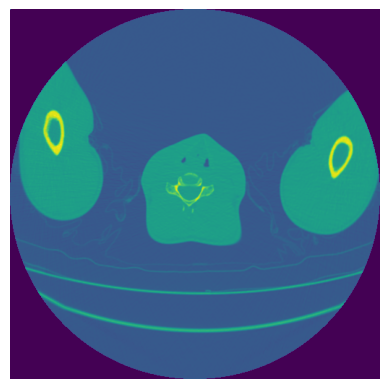

In [2]:
ds = dcmread('../data/raw/norma_anon/norma_anon/10000E6B_anon', force=True)

# Выводим информацию
print("DICOM информация:")
print(f"Модальность: {ds.Modality}")
print(f"Размер: {ds.Rows}x{ds.Columns}")
print(f"Срезы: {getattr(ds, 'NumberOfFrames', 1)}")

# Показываем изображение
pixel_data = ds.pixel_array
num_frames = getattr(ds, 'NumberOfFrames', 1)

if num_frames > 1:
    plt.imshow(pixel_data[num_frames//2])
else:
    plt.imshow(pixel_data)

plt.axis('off')
plt.show()

In [3]:
# Путь к папке с DICOM файлами
folder_path = '../data/raw/norma_anon/norma_anon'
dicom_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files.sort()

print(f"Найдено {len(dicom_files)} DICOM файлов")

Найдено 451 DICOM файлов


📂 Обнаружена папка: ../data/raw/norma_anon/norma_anon


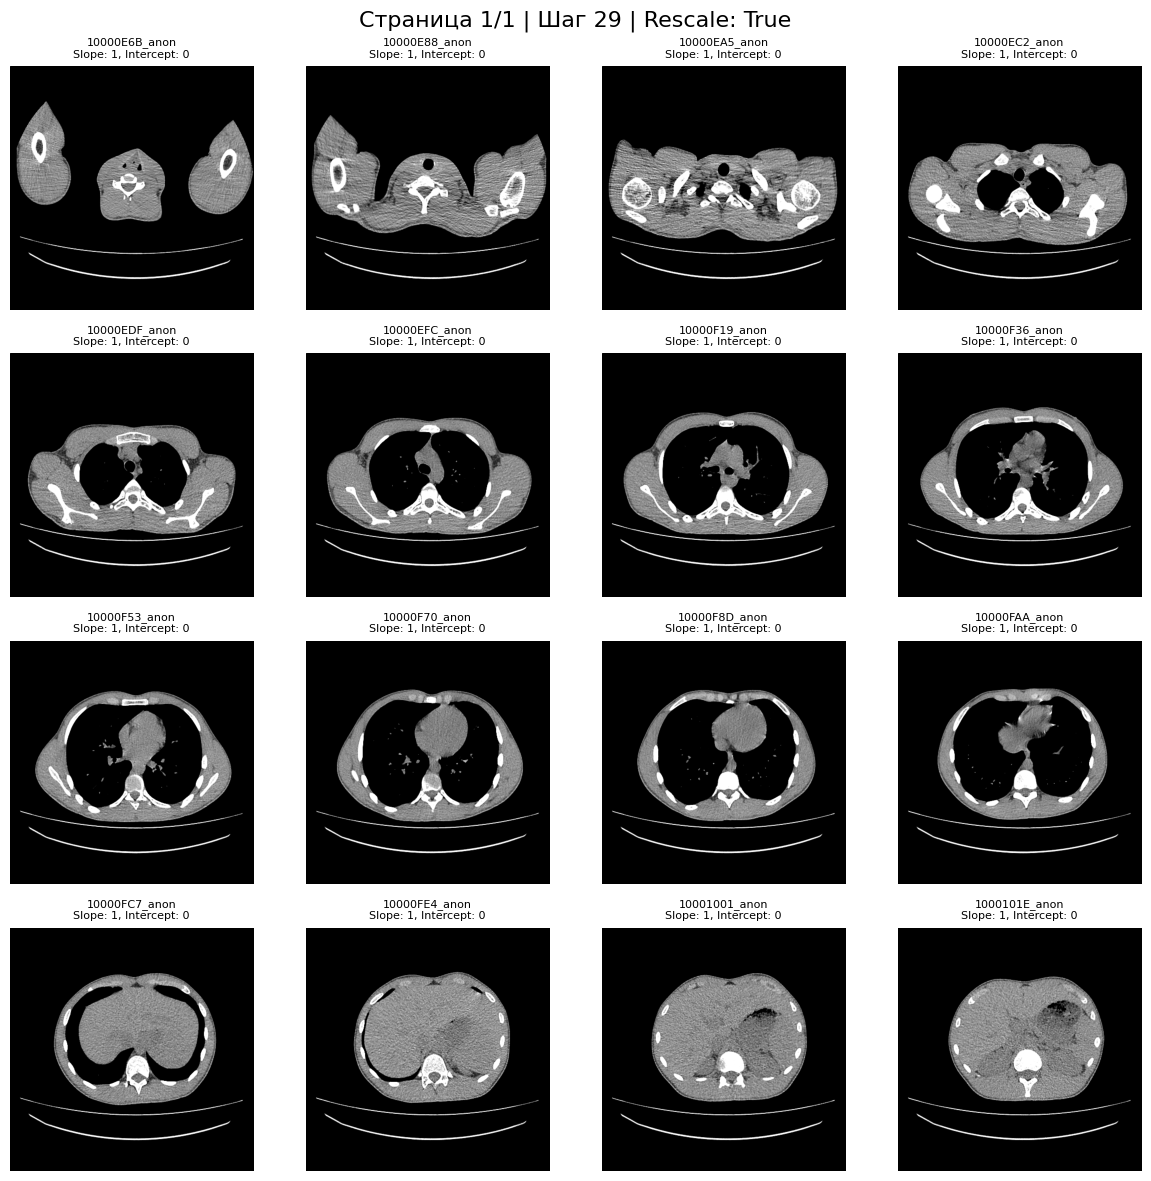

In [4]:
visualize_dicom(
        folder_path,
        step=29,
        grid_rows=4,
        grid_cols=4,
        apply_rescaling=True,
        apply_windowing=True
    )

Посчитаем статистику 

**mean_hu** (средняя плотность тканей в единицах Хаунсфилда (Hounsfield Units/HU))

Показывает общую "среднюю яркость" исследования

**std_hu** (Стандартное отклонение HU):

Показывает, насколько разнородна плотность тканей в исследовании

Высокое значение означает большую вариабельность плотностей (например, при наличии и воздушных, и плотных участков)

Низкое значение означает однородность тканей

**pct_low_attenuation** (Процент низкоаттенуированной ткани):

Показывает долю ткани с низкой плотностью (ниже определенного порога, обычно -950 HU)

Важный показатель при анализе легких, особенно для оценки эмфиземы

Чем выше этот процент, тем больше участков с патологически низкой плотностью

Успешно загружено срезов: 451
Срезы отсортированы по позиции
Обнаружен gap между срезами: 0.800 мм
Размер вокселя: 0.782 × 0.782 × 0.800 мм
Объем вокселя: 0.489 мм³
Размер объема: (451, 512, 512)
Диапазон HU: [-2048.0, 1731.0]


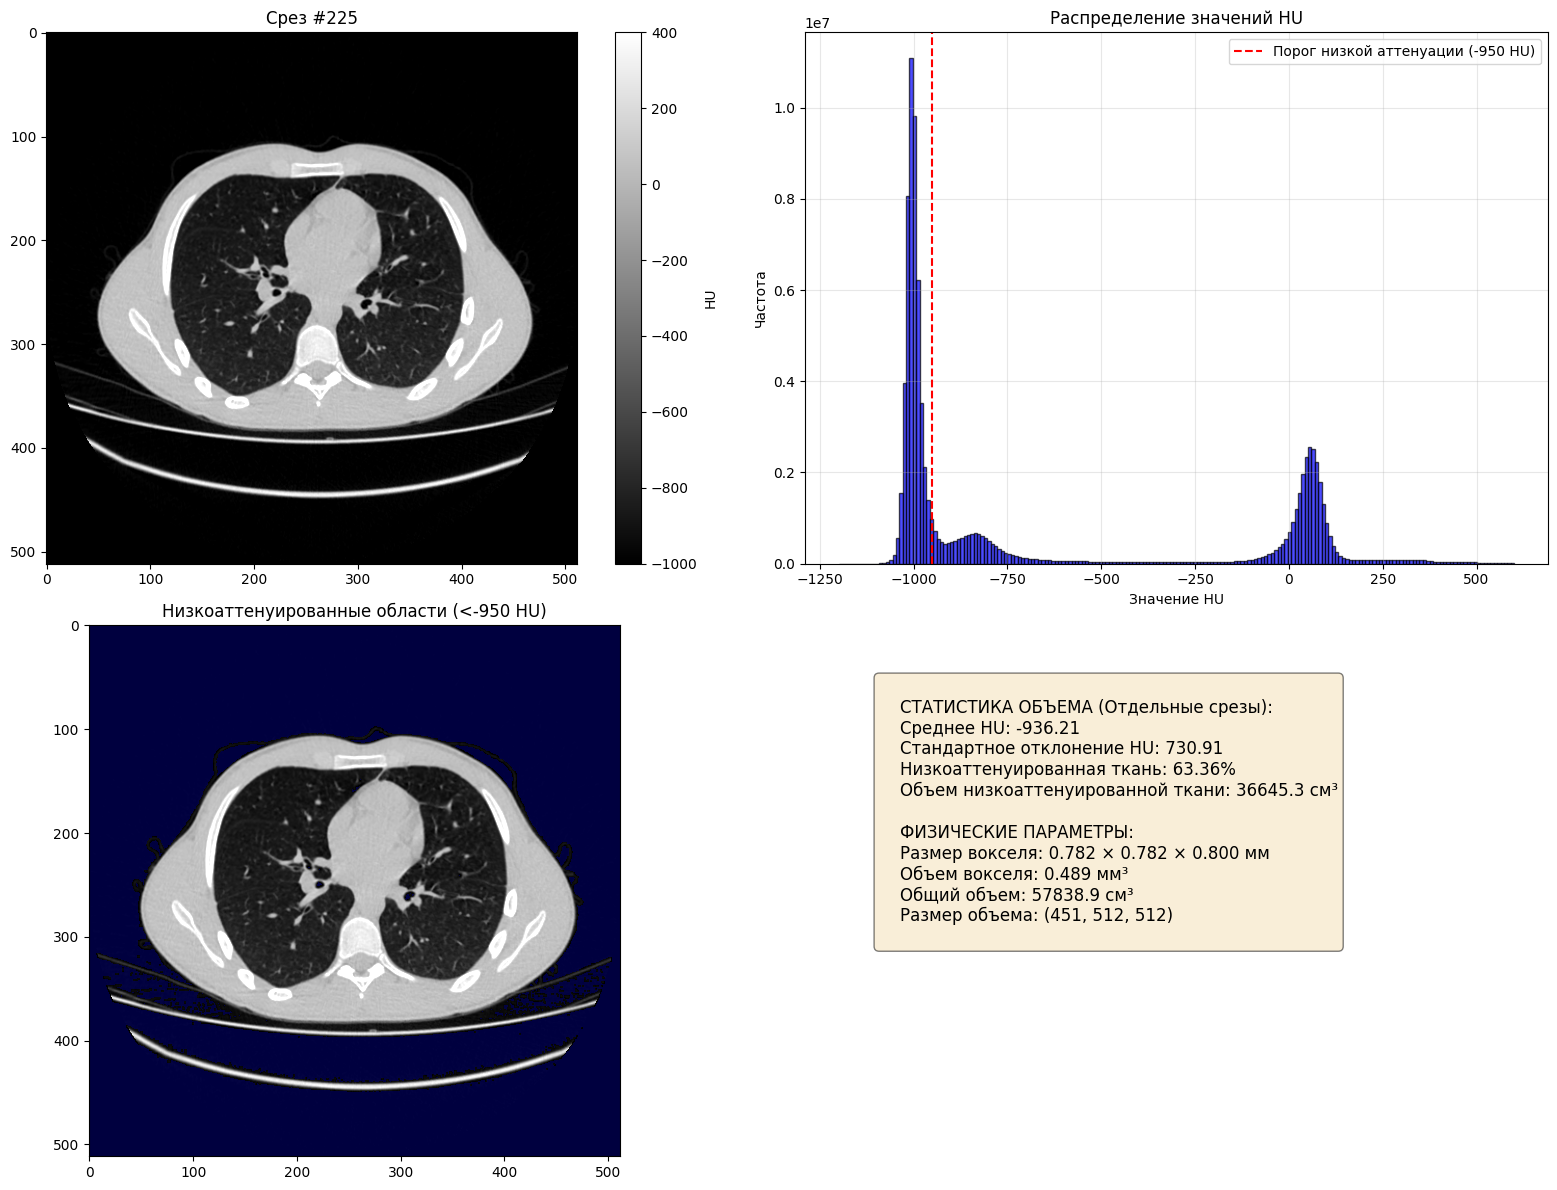

In [5]:
# Анализ всего объема 
mean_hu, std_hu, pct_low, metadata = analyze_dicom_volume(
    folder_path, 
    low_att_threshold=-950,
    visualize=True
)

### Метаданные

In [6]:
# Создаем список для хранения метаданных
metadata_list = []

# Читаем метаданные из первого файла (они обычно одинаковые для всех срезов)
first_file = os.path.join(folder_path, dicom_files[0])
ds = dcmread(first_file, force=True)

In [7]:
norma_metadata = analyze_dicom_series(folder_path)
norma_metadata

Найдено 451 DICOM файлов

Тип файла: Стандартный CT

=== ПАРАМЕТРЫ ИССЛЕДОВАНИЯ ===
Тип сканера: TOSHIBA Aquilion PRIME
Модальность: CT
Область исследования: CHEST
Тип изображения: ['ORIGINAL', 'PRIMARY', 'AXIAL']

=== ПАРАМЕТРЫ СКАНИРОВАНИЯ ===
Напряжение на трубке (кВ): 120
Ток на трубке (мА): 80
Экспозиция (мАс): 40
Толщина среза (мм): 1.0
Алгоритм реконструкции: FC07
Шаг спирали (Pitch): 1.388
Объемная доза КТ (мГр): 2.6

=== ГЕОМЕТРИЧЕСКИЕ ПАРАМЕТРЫ ===
Размер изображения: 512×512 пикселей
Размер пикселя: [0.782, 0.782] мм
Диаметр реконструкции: 400.39 мм

=== КООРДИНАТНАЯ СИСТЕМА ===
Положение пациента: FFS
Ориентация пациента: ['L', 'P']
Ориентация изображения: [1.00000, 0.00000, 0.00000, 0.00000, 1.00000, 0.00000]
Позиция среза (первого): [-201.7574, -177.3433, 1954.50]
Локация среза: +0.00 мм

=== ПАРАМЕТРЫ ВИЗУАЛИЗАЦИИ ===
Фотометрическая интерпретация: MONOCHROME2
Битовая глубина: 16 бит
Представление пикселей: со знаком

=== ПАРАМЕТРЫ ОКНА И RESCALE ===
Уровень окна: 40
Шир

filename  instance_number  z_position  rescale_slope  \
0    1000102D_anon              451      1594.5            1.0   
1    1000102C_anon              450      1595.3            1.0   
2    1000102B_anon              449      1596.1            1.0   
3    1000102A_anon              448      1596.9            1.0   
4    10001029_anon              447      1597.7            1.0   
..             ...              ...         ...            ...   
446  10000E6F_anon                5      1951.3            1.0   
447  10000E6E_anon                4      1952.1            1.0   
448  10000E6D_anon                3      1952.9            1.0   
449  10000E6C_anon                2      1953.7            1.0   
450  10000E6B_anon                1      1954.5            1.0   

     rescale_intercept  
0                  0.0  
1                  0.0  
2                  0.0  
3                  0.0  
4                  0.0  
..                 ...  
446                0.0  
447                0.0  
448                0.0  
449                0.0  
450                0.0  

[451 rows x 5 columns]

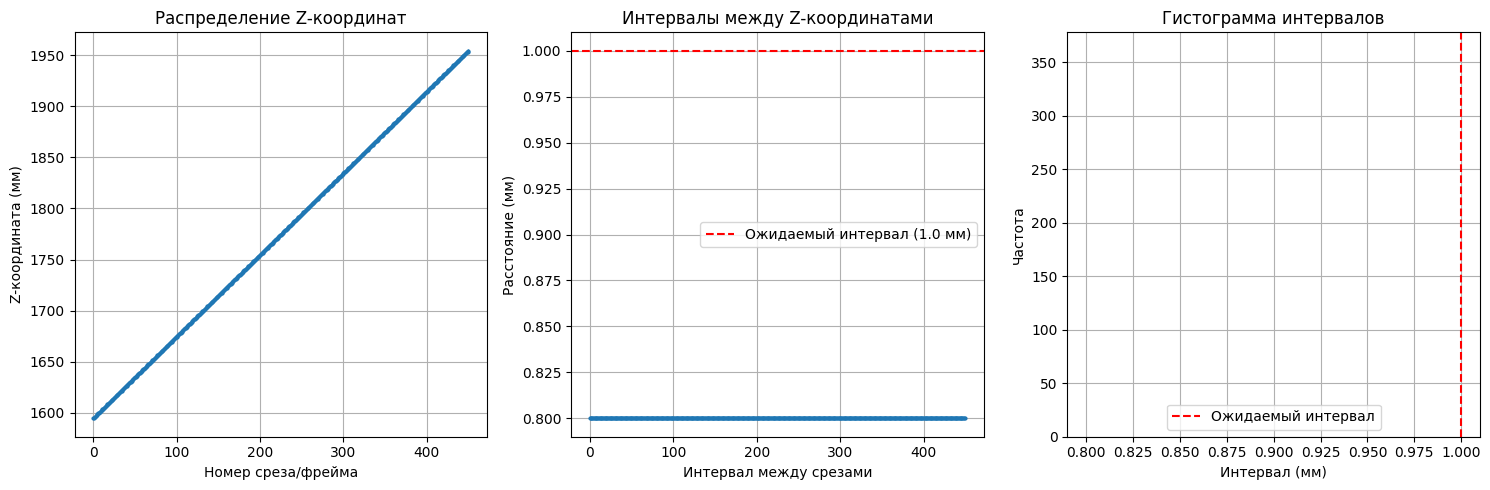

In [8]:
visualize_dicom_geometry(norma_metadata)

###  Анализ параметров сканирования КТ норма

**Обнаружено:** Реконструкция с перекрытием (overlapping reconstruction) — стандартная практика для улучшения качества 3D-визуализации.

---

** Расчеты и обоснование:**

**Исходные данные:**
- Количество срезов: 451
- Z-диапазон: 1954.50 - 1594.50 = 360.00 мм
- Slice Thickness: 1.0 мм (толщина реконструированного среза)
- Spiral Pitch Factor: 1.388

**Расчет шага реконструкции:**
Δz = Общий диапазон / (N срезов - 1) = 360.00 / 450 = 0.80 мм

**Расчет коэффициента перекрытия:**
Overlap = 1 - (Шаг / Толщина) = 1 - (0.8 / 1.0) = 0.2 (20%)


**📊 Технические параметры:**
- **Data Collection Diameter:** 500.00 мм (физический сбор данных)
- **Reconstruction Diameter:** 400.39 мм (поле реконструкции)
- **Покрытие за оборот:** Pitch × Коллимация = 1.388 × (N×1.0 мм)

**✅ Вывод:** Система работает в штатном режиме. Перекрытие в 20% улучшает качество 3D-реконструкций и повышает точность диагностики за счет исключения "ступенчатости" и улучшения видимости мелких образований на нескольких соседних срезах.
Таким образом реальный размер вокселя: 0.782×0.782×0.8 мм

## Пневмония

In [9]:
# Путь к папке с DICOM файлами
folder_path = '../data/raw/pneumonia_anon/pneumonia_anon'
dicom_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files.sort()

print(f"Найдено {len(dicom_files)} DICOM файлов")

Найдено 367 DICOM файлов


📂 Обнаружена папка: ../data/raw/pneumonia_anon/pneumonia_anon


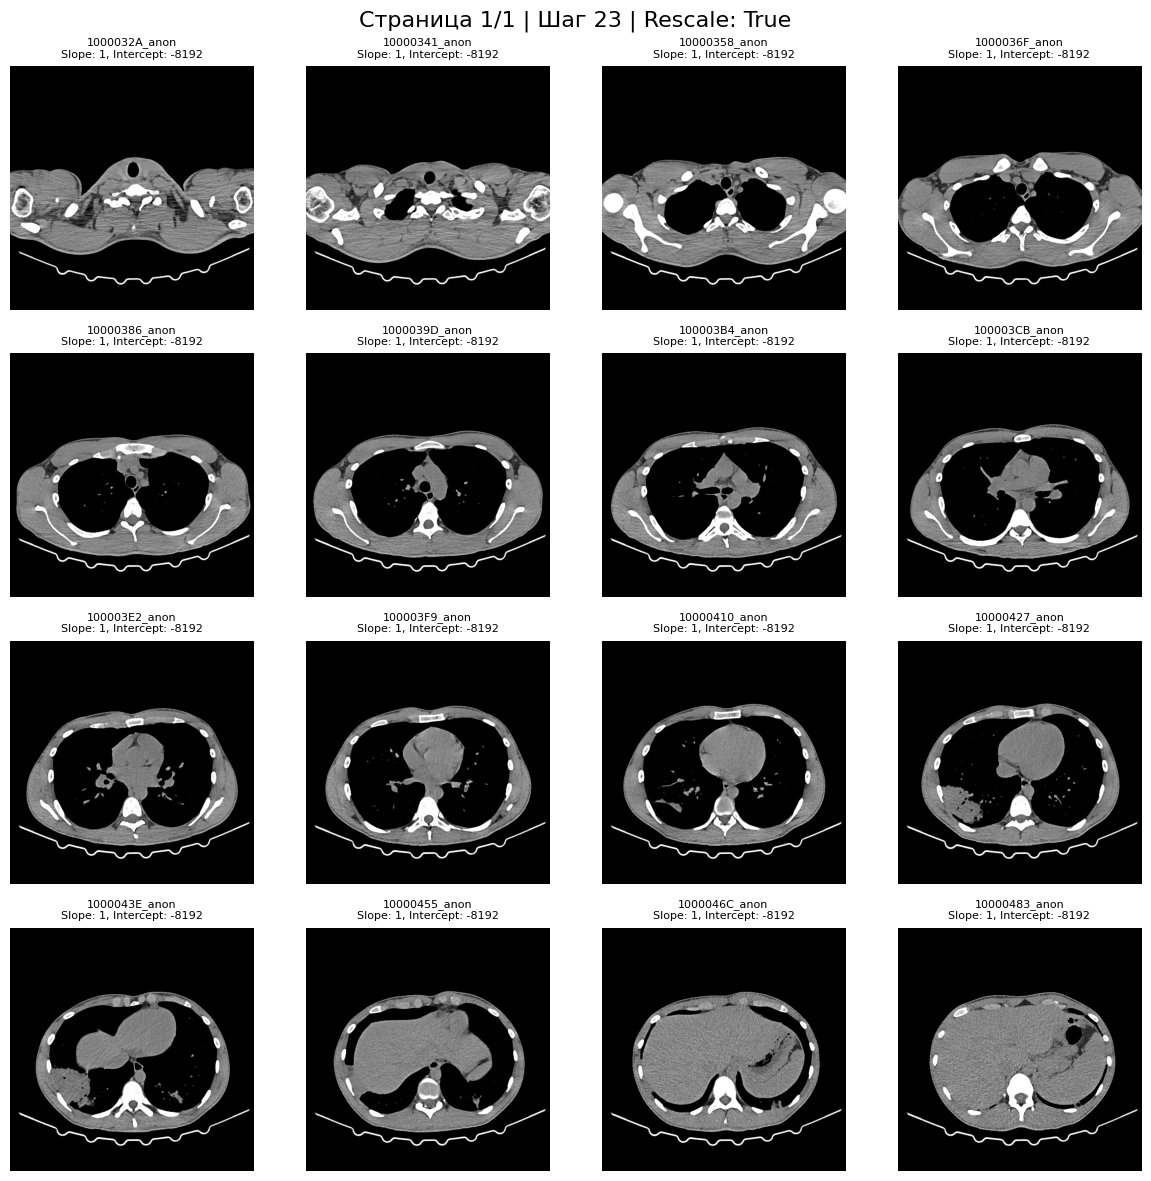

In [10]:
visualize_dicom(
        folder_path,
        step=23,
        grid_rows=4,
        grid_cols=4,
        apply_rescaling=True,
        apply_windowing=True
    )

Успешно загружено срезов: 367
Срезы отсортированы по позиции
Обнаружен gap между срезами: 0.800 мм
Размер вокселя: 0.752 × 0.752 × 0.800 мм
Объем вокселя: 0.452 мм³
Размер объема: (367, 512, 512)
Диапазон HU: [-8192.0, 1935.0]


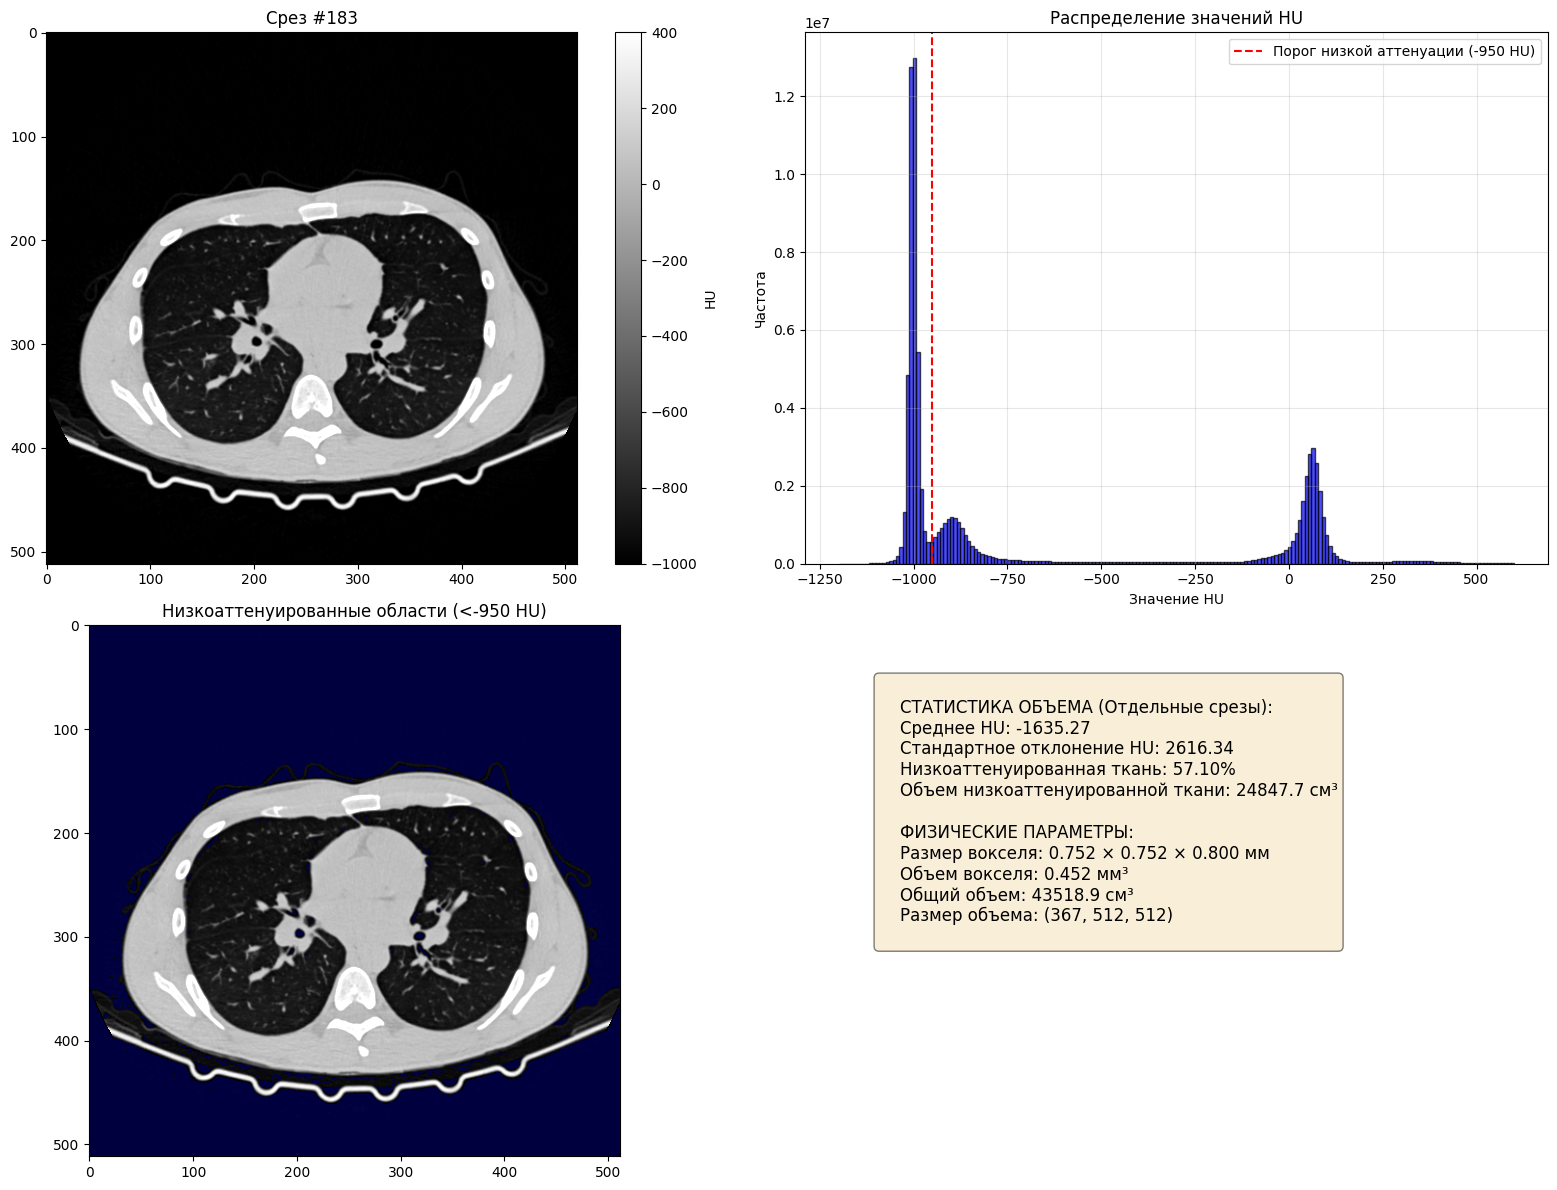

In [11]:
# Анализ всего объема 
mean_hu, std_hu, pct_low, metadata = analyze_dicom_volume(
    folder_path, 
    low_att_threshold=-950,
    visualize=True
)

In [12]:
# Создаем список для хранения метаданных
metadata_list = []

# Читаем метаданные из первого файла (они обычно одинаковые для всех срезов)
first_file = os.path.join(folder_path, dicom_files[0])
ds = dcmread(first_file, force=True)
#ds

In [13]:
pnevma_metadata = analyze_dicom_series(folder_path)
pnevma_metadata

Найдено 367 DICOM файлов

Тип файла: Стандартный CT

=== ПАРАМЕТРЫ ИССЛЕДОВАНИЯ ===
Тип сканера: Siemens Healthineers SOMATOM go.Top
Модальность: CT
Область исследования: CHEST
Тип изображения: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']

=== ПАРАМЕТРЫ СКАНИРОВАНИЯ ===
Напряжение на трубке (кВ): 100
Ток на трубке (мА): 673
Экспозиция (мАс): 148
Толщина среза (мм): 1
Алгоритм реконструкции: ['Br36f', '3']
Шаг спирали (Pitch): 1.5
Объемная доза КТ (мГр): 8.06567125364

=== ГЕОМЕТРИЧЕСКИЕ ПАРАМЕТРЫ ===
Размер изображения: 512×512 пикселей
Размер пикселя: [0.751953125, 0.751953125] мм
Диаметр реконструкции: 385 мм

=== КООРДИНАТНАЯ СИСТЕМА ===
Положение пациента: HFS
Ориентация пациента: N/A
Ориентация изображения: [1, 0, 0, 0, 1, 0]
Позиция среза (первого): [-194.1240234375, -328.6240234375, -891.407]
Локация среза: -891.407 мм

=== ПАРАМЕТРЫ ВИЗУАЛИЗАЦИИ ===
Фотометрическая интерпретация: MONOCHROME2
Битовая глубина: 16 бит
Представление пикселей: без знака

=== ПАРАМЕТРЫ ОКНА И RESC

filename  instance_number  z_position  rescale_slope  \
0    10000498_anon              367   -1184.207            1.0   
1    10000497_anon              366   -1183.407            1.0   
2    10000496_anon              365   -1182.607            1.0   
3    10000495_anon              364   -1181.807            1.0   
4    10000494_anon              363   -1181.007            1.0   
..             ...              ...         ...            ...   
362  1000032E_anon                5    -894.607            1.0   
363  1000032D_anon                4    -893.807            1.0   
364  1000032C_anon                3    -893.007            1.0   
365  1000032B_anon                2    -892.207            1.0   
366  1000032A_anon                1    -891.407            1.0   

     rescale_intercept  
0              -8192.0  
1              -8192.0  
2              -8192.0  
3              -8192.0  
4              -8192.0  
..                 ...  
362            -8192.0  
363            -8192.0  
364            -8192.0  
365            -8192.0  
366            -8192.0  

[367 rows x 5 columns]

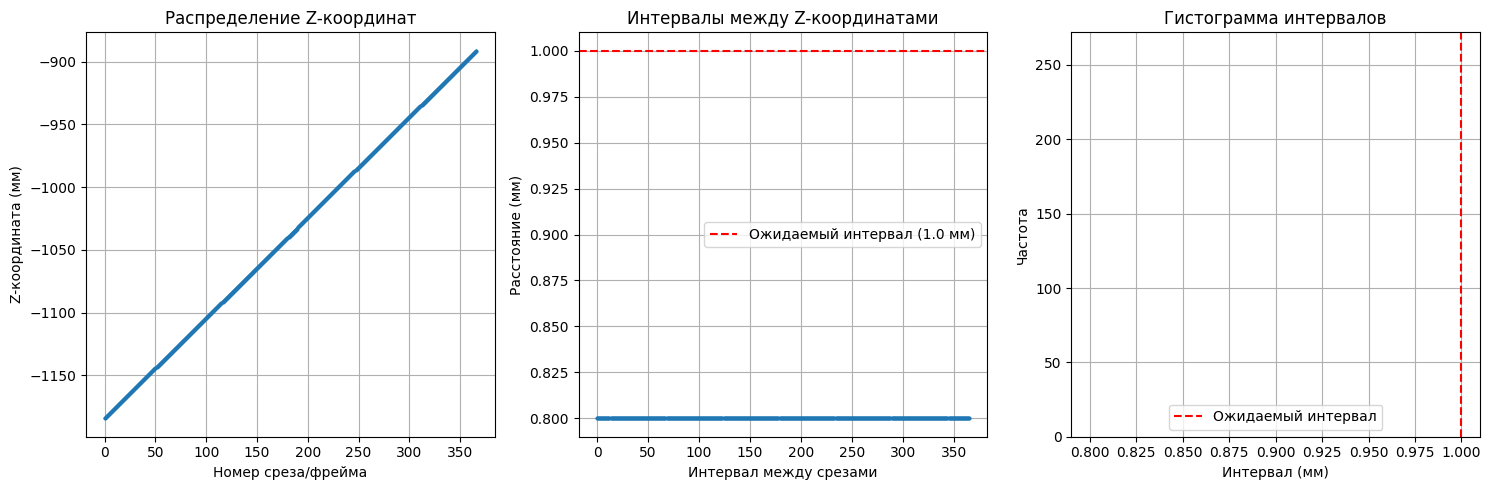

In [14]:
visualize_dicom_geometry(pnevma_metadata)

## Пневмоторекс

In [15]:
# Путь к папке с DICOM файлами
folder_path = '../data/raw/pneumotorax_anon/pneumotorax_anon'
dicom_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
dicom_files.sort()

print(f"Найдено {len(dicom_files)} DICOM файлов")

Найдено 1 DICOM файлов


In [16]:
file_path = "../data/raw/pneumotorax_anon/pneumotorax_anon/10000CF6_anon"
frames = get_number_of_frames(file_path)
print(f"Файл содержит {frames} фреймов.")

Файл содержит 476 фреймов.


In [17]:
print_dicom_rescale_info(folder_path)

Rescale параметры DICOM файлов:
--------------------------------------------------
10000CF6_anon: Slope=1, Intercept=0


📄 Обнаружен файл: ../data/raw/pneumotorax_anon/pneumotorax_anon/10000CF6_anon
Файл содержит 476 фреймов.
Отображаем 16 фреймов из 476 (шаг 29) на 1 страницах.


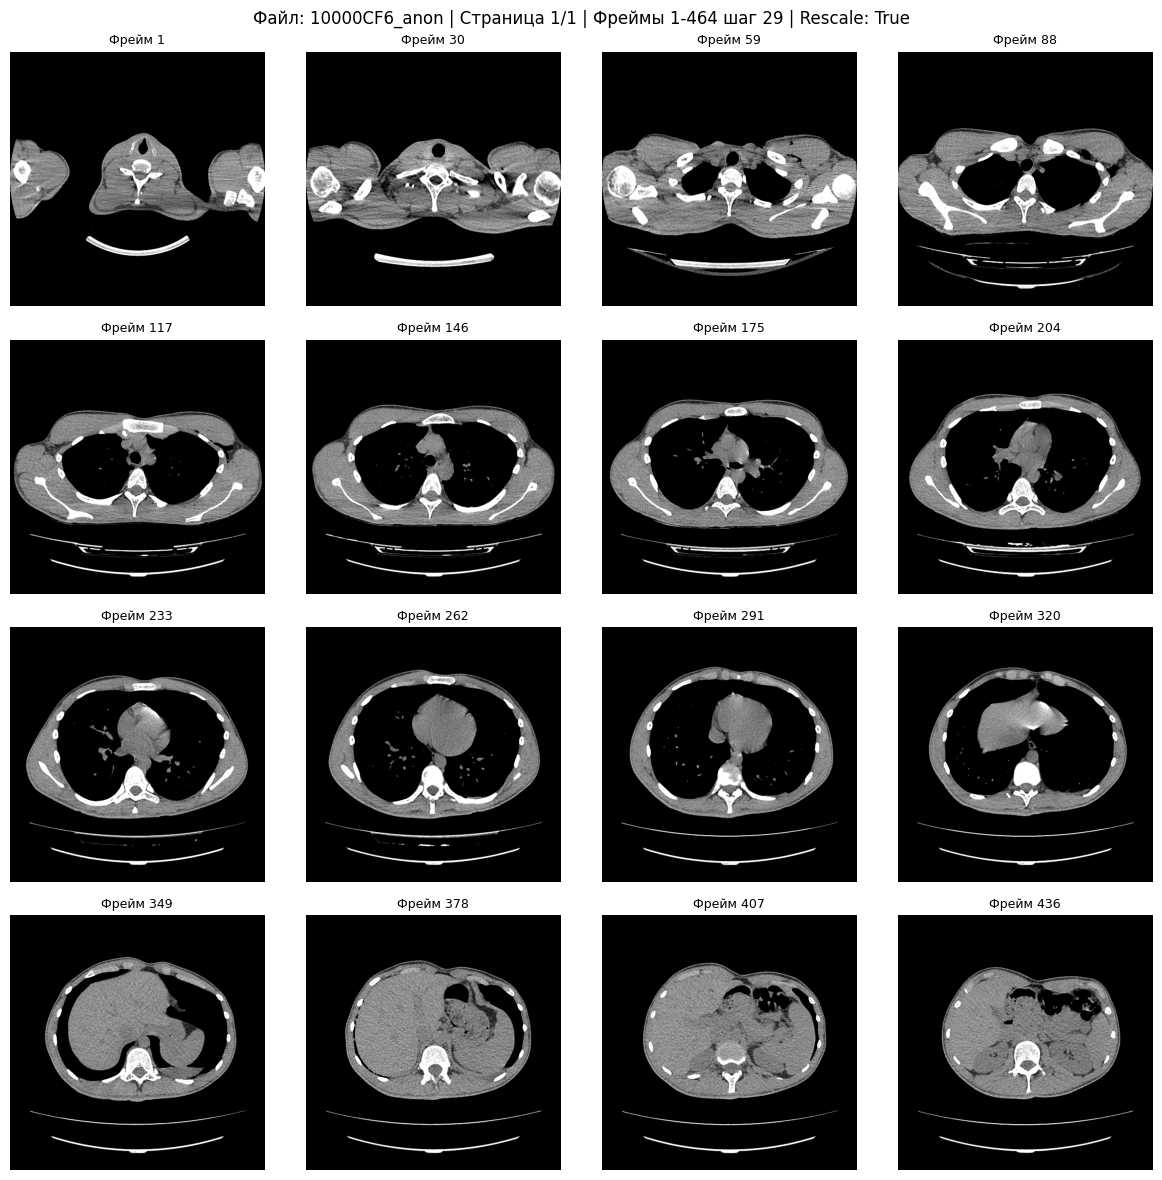

In [18]:
visualize_dicom(
        file_path,
        step=29,
        grid_rows=4,
        grid_cols=4,
        apply_rescaling=True,
        apply_windowing=True,
        start_frame=1,
        max_frames=464
    )

Успешно загружен многосрезовый файл: 10000CF6_anon
Размер файла: (476, 512, 512)
Расчетное расстояние между кадрами: 0.800 мм
Размер вокселя: 1.000 × 1.000 × 0.800 мм
Объем вокселя: 0.800 мм³
Размер объема: (476, 512, 512)
Диапазон HU: [-2048.0, 3097.0]


/Users/irinamistulova/PycharmProjects/hackathon_imoscow2025/chest_ct_ai_classifier/src/utils/data_analysis.py:483: UserWarning: PixelSpacing не найден, используется значение по умолчанию 1.0 мм
  warnings.warn("PixelSpacing не найден, используется значение по умолчанию 1.0 мм")
/Users/irinamistulova/PycharmProjects/hackathon_imoscow2025/chest_ct_ai_classifier/src/utils/data_analysis.py:492: UserWarning: SliceThickness/SpacingBetweenSlices не найден, используется значение по умолчанию 1.0 мм
  warnings.warn("SliceThickness/SpacingBetweenSlices не найден, используется значение по умолчанию 1.0 мм")


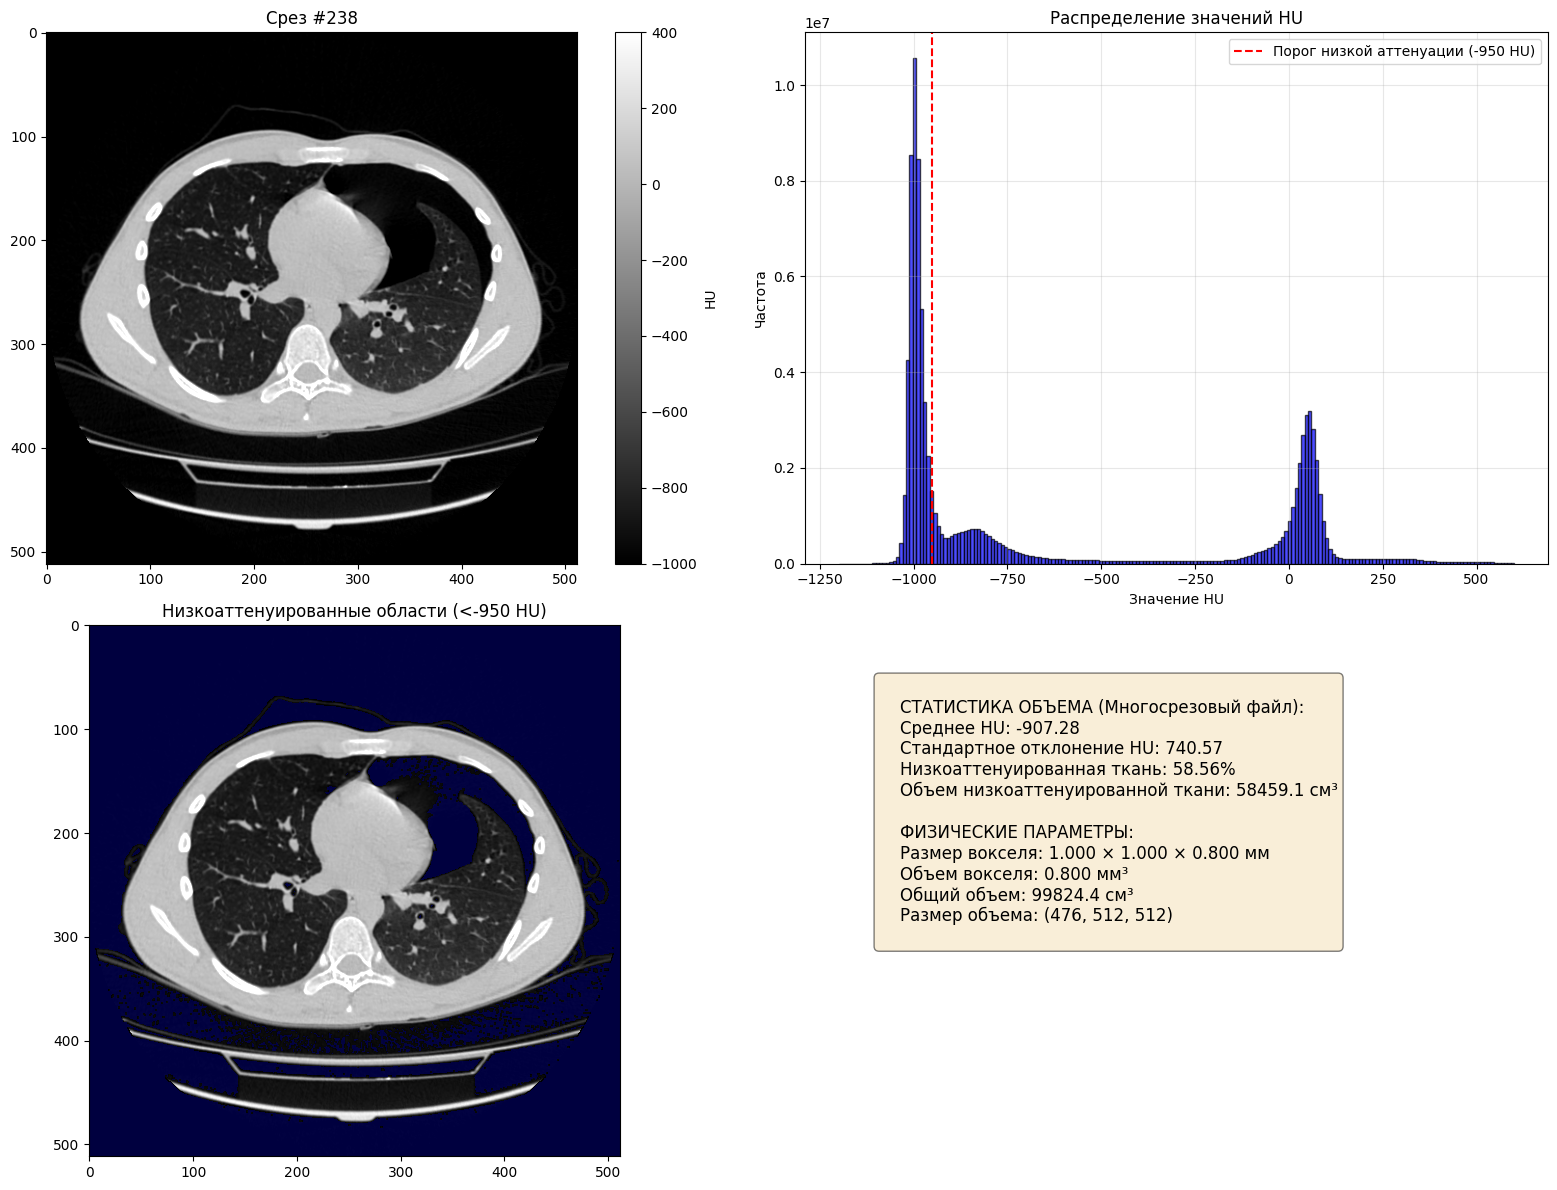

In [19]:
# Анализ всего объема 
mean_hu, std_hu, pct_low, metadata = analyze_dicom_volume(
    file_path, 
    low_att_threshold=-950,
    visualize=True
)

In [20]:
# Создаем список для хранения метаданных
metadata_list = []

# Читаем метаданные из первого файла (они обычно одинаковые для всех срезов)
first_file = os.path.join(folder_path, dicom_files[0])
ds = dcmread(first_file, force=True)

In [21]:
ds

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Enhanced CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.2462171185.19116.1754560222.2500
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.9
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_369'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'VOLUME']
(0008,0016) SOP Class UID                       UI: Enhanced CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.2462171185.19116.1754560222.2500
(0008,0020) Study Date     

In [22]:
pnevmotorex_metadata = analyze_dicom_series(folder_path)
pnevmotorex_metadata

Найдено 1 DICOM файлов

Тип файла: Enhanced CT
Количество фреймов: 476

=== ПАРАМЕТРЫ ИССЛЕДОВАНИЯ ===
Тип сканера: TOSHIBA Aquilion
Модальность: CT
Область исследования: CHEST
Тип изображения: ['ORIGINAL', 'PRIMARY', 'VOLUME']

=== ПАРАМЕТРЫ СКАНИРОВАНИЯ ===
Напряжение на трубке (кВ): N/A
Ток на трубке (мА): N/A
Экспозиция (мАс): N/A
Толщина среза (мм): N/A
Алгоритм реконструкции: N/A
Шаг спирали (Pitch): 1.484
Объемная доза КТ (мГр): 3.8

=== ГЕОМЕТРИЧЕСКИЕ ПАРАМЕТРЫ ===
Размер изображения: 512×512 пикселей
Размер пикселя: [0.782, 0.782] мм
Диаметр реконструкции: 400.39 мм

=== КООРДИНАТНАЯ СИСТЕМА ===
Положение пациента: HFS
Ориентация пациента: ['L', 'P']
Ориентация изображения: N/A
Позиция среза (первого): [-201.757, -199.8043, -266.00]
Локация среза: +0.00 мм

=== ПАРАМЕТРЫ ВИЗУАЛИЗАЦИИ ===
Фотометрическая интерпретация: MONOCHROME2
Битовая глубина: 16 бит
Представление пикселей: со знаком

=== ПАРАМЕТРЫ ОКНА И RESCALE ===
Уровень окна: N/A
Ширина окна: N/A
Наклон пересчета: 1
Ин

filename  instance_number  z_position  rescale_slope  rescale_intercept
0    frame_0475              476      -646.0            1.0                0.0
1    frame_0474              475      -645.2            1.0                0.0
2    frame_0473              474      -644.4            1.0                0.0
3    frame_0472              473      -643.6            1.0                0.0
4    frame_0471              472      -642.8            1.0                0.0
..          ...              ...         ...            ...                ...
471  frame_0004                5      -269.2            1.0                0.0
472  frame_0003                4      -268.4            1.0                0.0
473  frame_0002                3      -267.6            1.0                0.0
474  frame_0001                2      -266.8            1.0                0.0
475  frame_0000                1      -266.0            1.0                0.0

[476 rows x 5 columns]

## Сравнение параметров КТ-снимков: Норма vs Пневмония vs Пневмоторакс

| Параметр                  | Случай 1 (Норма)      | Случай 2 (Пневмония)   | Случай 3 (Пневмоторакс) | Комментарий |
|---------------------------|------------------------|-------------------------|--------------------------|-------------|
| **Производитель сканера** | TOSHIBA                | Siemens                 | TOSHIBA Aquilion         | разные алгоритмы реконструкции и шумовые характеристики |
| **Напряжение (кВ)**       | 120                    | 100                     | 120                      | влияет на контрастность тканей и проникающую способность излучения; **требуется восстановление или оценка по протоколу** |
| **Ток (мА) / Экспозиция** | 80 мА / 40 мАс         | 673 мА / 148 мАс        | 116/58                     | сильно влияет на уровень шума и качество изображения; **данные отсутствуют — может потребоваться аппроксимация** |
| **Доза (мГр)**            | 2.6                    | 8.07                    | 27.5                      | прямо влияет на соотношение сигнал/шум (SNR); **необходимо дополнить из протокола, если доступно** |
| **Размер пикселя (мм)**   | 0.782                  | 0.752                   | 0.782      | **требуется ресемплинг к единому разрешению для обучения модели**; предположительно ~1.0 мм/пиксель |
| **Интерцепт пересчёта**   | 0                      | -8192                   | 0                        | **определяет абсолютные значения HU; без коррекции модель увидит разные "единицы измерения"** |
| **Представление пикселей**| Со знаком              | Без знака               | Со знаком                | **влияет на диапазон значений и интерпретацию HU; требует нормализации** |



# Подбор окон

Шкала Хаунсфилда (HU) — это количественная шкала рентгеновской плотности, используемая в компьютерной томографии. За основу приняты:
- **Вода = 0 HU**
- **Воздух = -1000 HU**

**Основные ткани и материалы**

| Ткань / Материал         | HU Значения              |
|--------------------------|--------------------------|
| Воздух                   | -1000 HU                 |
| Жир                      | -120 to -90 HU           |
| Вода                     | 0 HU                     |
| Мягкие ткани             | 20–50 HU                 |
| Кровь                    | 30–45 HU                 |
| Мышцы                    | 35–55 HU                 |
| Печень                   | 40–60 HU                 |
| Кости                    | 300–1000+ HU             |


**Дополнительные материалы и состояния**

| Ткань / Материал         | HU Значения              |
|--------------------------|--------------------------|
| Лёгкие (инспирация)      | -800 to -600 HU          |
| Лёгкие (экспирация)      | -500 to -200 HU          |
| Контрастное вещество     | 100–3000 HU              |
| Кальцинаты               | 150–2000 HU              |
| Зубная эмаль             | 2000–3000 HU             |


**Клиническое значение HU**

- **Отрицательные значения**:  
  ➤ Воздух, жир, лёгочная ткань.

- **Около 0 HU**:  
  ➤ Вода, спинномозговая жидкость (CSF).

- **Положительные значения (умеренные)**:  
  ➤ Мягкие ткани, внутренние органы (печень, селезёнка, почки, мышцы).

- **Высокие положительные значения**:  
  ➤ Кости, кальцификаты, металлы, контрастные агенты.


Rescale Slope: 1, Intercept: -8192
Диапазон HU значений: -8192.0 - 1584.0


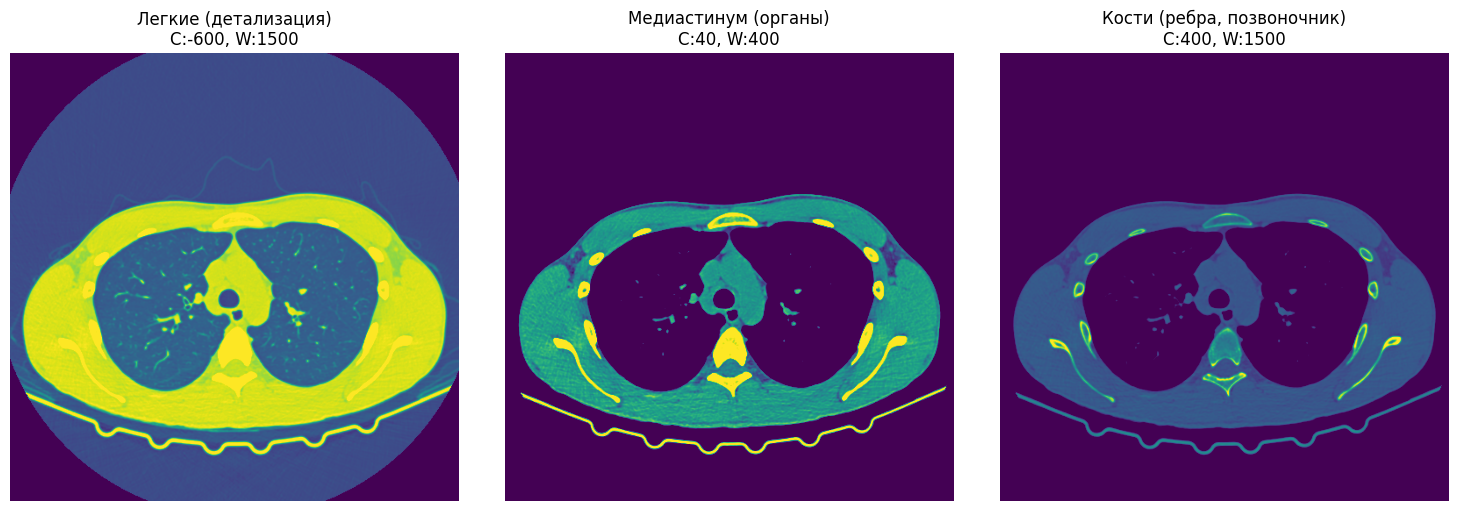

In [23]:
# Загружаем DICOM файл
file_path = '../data/raw/pneumonia_anon/pneumonia_anon/100003A0_anon'
#file_path = '../data/raw/norma_anon/norma_anon/10000E6B_anon'
ds = dcmread(file_path, force=True)

# Получаем изображение в HU (pixel_array уже в HU для CT)
ct_image = ds.pixel_array.astype(np.float32)

# Проверяем наличие Rescale Slope/Intercept в метаданных
rescale_slope = getattr(ds, 'RescaleSlope', 1.0)
rescale_intercept = getattr(ds, 'RescaleIntercept', 0.0)

# Если нужно преобразовать в HU 
if rescale_slope != 1.0 or rescale_intercept != 0.0:
    ct_image = ct_image * rescale_slope + rescale_intercept

print(f"Rescale Slope: {rescale_slope}, Intercept: {rescale_intercept}")
print(f"Диапазон HU значений: {ct_image.min():.1f} - {ct_image.max():.1f}")

optimal_windows = {
    'Легкие (детализация)': (-600, 1500),
    'Медиастинум (органы)': (40, 400),
    'Кости (ребра, позвоночник)': (400, 1500) # 
}

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for (ax, (window_name, (center, width))) in zip(axes, optimal_windows.items()):
    windowed_image = apply_ct_window(ct_image, center, width)
    ax.imshow(windowed_image)
    ax.set_title(f'{window_name}\nC:{center}, W:{width}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [24]:
def interactive_ct_window(window_center=40, window_width=400):
    """Интерактивная настройка окна"""
    windowed_image = apply_ct_window(ct_image, window_center, window_width)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(windowed_image, cmap='gray')
    plt.title(f'CT Window: Center={window_center}, Width={window_width}')
    plt.axis('off')
    plt.show()
    
    # Показываем гистограмму HU значений
    plt.figure(figsize=(10, 3))
    plt.hist(ct_image.flatten(), bins=200, range=(-1000, 1000), alpha=0.7)
    plt.axvline(window_center - window_width/2, color='r', linestyle='--', label='Window Min')
    plt.axvline(window_center + window_width/2, color='r', linestyle='--', label='Window Max')
    plt.axvline(window_center, color='g', linestyle='-', label='Center')
    plt.xlabel('HU Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Histogram of HU Values with Current Window')
    plt.show()


In [25]:
# Создаем интерактивные ползунки
interact(interactive_ct_window,
         window_center=IntSlider(value=40, min=-1000, max=1000, step=10, description='Center'),
         window_width=IntSlider(value=400, min=50, max=2000, step=50, description='Width'))

interactive(children=(IntSlider(value=40, description='Center', max=1000, min=-1000, step=10), IntSlider(value…

<function __main__.interactive_ct_window(window_center=40, window_width=400)>

 **Настройки окон для КТ:**
- **Лёгочные окна**: Центр `-600`, Ширина `1500`
- **Мягкотканые окна**: Центр `40`, Ширина `400`
- **Костные окна**: Центр `400`, Ширина `1500`